In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pfi.utils import DNN, simulate_toggle_switch, X_from_snapshots
from pfi.score import ScoreMatching

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

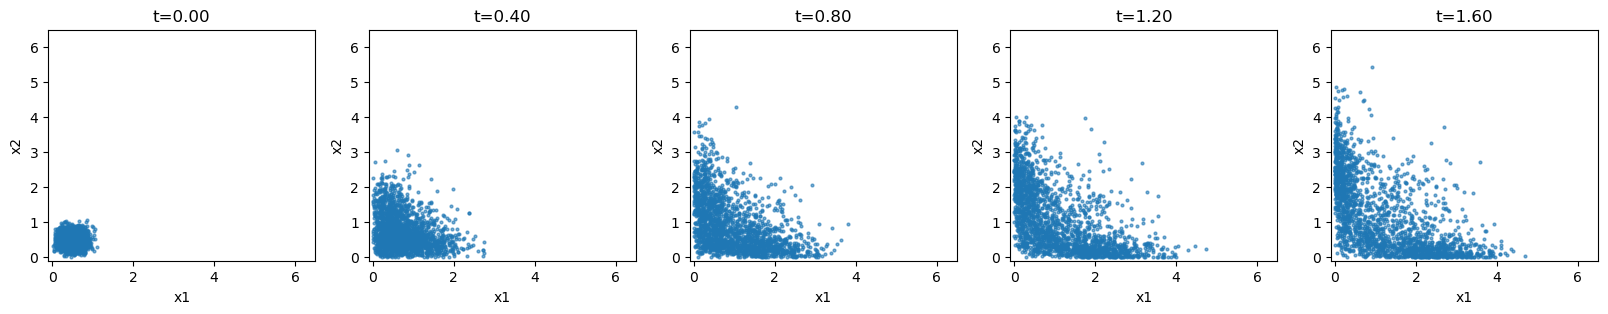

In [2]:
# Toggle-switch simulation parameters (from example.ipynb)
model_params = np.array([2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 4.0])
ndim = 2
vol = 4.0
nsamples = 2000
nsnaps = 5
seed = 0
maxiter = 200
gr = 2.0
growth_flag = True

np.random.seed(seed)
torch.manual_seed(seed)
init = np.random.uniform(0.25, 0.75, (ndim, nsamples))
samples_full, tt = simulate_toggle_switch(
    nsamples=nsamples,
    init=init,
    nsnaps=nsnaps,
    ndim=ndim,
    seed=seed,
    maxiter=maxiter,
    model_params=model_params,
    vol=vol,
    gr=gr,
    growth_flag=growth_flag,
)

fig, axes = plt.subplots(1, nsnaps, figsize=(4 * nsnaps, 3))
for k in range(nsnaps):
    ax = axes[k]
    xk = samples_full[k][:2000]
    ax.scatter(xk[:, 0], xk[:, 1], s=4, alpha=0.6)
    ax.set_title(f"t={tt[k]:.2f}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(-0.1,6.5)
    ax.set_ylim(-0.1,6.5)
plt.show()


In [3]:
mass_vec = np.ones((nsnaps,))
for k in range(0,nsnaps):
    mass_vec[k] = len(samples_full[k])/len(samples_full[0])
    print(" # samples at time ", np.round(tt[k],3), ":", len(samples_full[k]))
mass_vec = torch.tensor(mass_vec,dtype=torch.float32,device=device)
print(" ground-truth mass ratio over time ", mass_vec)

 # samples at time  0.0 : 2003
 # samples at time  0.4 : 2509
 # samples at time  0.8 : 3383
 # samples at time  1.2 : 5249
 # samples at time  1.6 : 8799
 ground-truth mass ratio over time  tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


In [4]:
X = X_from_snapshots(samples_full, tt)

Np = 50
score_model = DNN([ndim + 2, Np, Np, Np, Np, Np, ndim], activation=nn.ELU()).to(device)

score_reg = ScoreMatching(
    model=score_model,
    solver="dsm",
    solver_kwargs=dict(L=10, n_epochs=5000, bs=None, adp_flag=1, lr=5e-4),
    device=device,
)
score_reg.fit(X)


/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain = torch.tensor(x_train, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xdata = torch.tensor(x_data, dtype=torch.float32).to(device)
DSM:   0%|          | 13/5000 [00:00<01:07, 73.40it/s, lo

epoch: 0 c_: [0.17901836 0.20052746 0.20544496 0.2083262  0.20668298]


DSM:  10%|█         | 519/5000 [00:04<00:37, 118.31it/s, loss=3.912e+00, lr=5.00e-04]

epoch: 500 c_: [0.09557027 0.16842595 0.20489374 0.31636965 0.21474038]


DSM:  20%|██        | 1017/5000 [00:09<00:33, 118.66it/s, loss=3.799e+00, lr=5.00e-04]

epoch: 1000 c_: [0.27221453 0.09852537 0.12204818 0.257726   0.24948594]


DSM:  30%|███       | 1523/5000 [00:13<00:31, 109.53it/s, loss=3.777e+00, lr=5.00e-04]

epoch: 1500 c_: [0.38469076 0.09495864 0.09664314 0.16341762 0.26028982]


DSM:  40%|████      | 2018/5000 [00:17<00:25, 115.92it/s, loss=3.763e+00, lr=5.00e-04]

epoch: 2000 c_: [0.46483815 0.05060641 0.06222273 0.3421066  0.08022614]


DSM:  50%|█████     | 2521/5000 [00:22<00:22, 109.33it/s, loss=3.697e+00, lr=5.00e-05]

epoch: 2500 c_: [0.24052964 0.13894773 0.11205578 0.324652   0.18381485]


DSM:  60%|██████    | 3020/5000 [00:26<00:16, 117.80it/s, loss=3.121e+00, lr=5.00e-05]

epoch: 3000 c_: [0.8077495  0.02690935 0.01638716 0.03811636 0.11083765]


DSM:  70%|███████   | 3520/5000 [00:31<00:12, 119.21it/s, loss=3.070e+00, lr=5.00e-05]

epoch: 3500 c_: [0.85528153 0.0267702  0.01281812 0.03904803 0.0660821 ]


DSM:  80%|████████  | 4024/5000 [00:35<00:08, 114.07it/s, loss=3.056e+00, lr=5.00e-05]

epoch: 4000 c_: [0.86840004 0.02591524 0.01142596 0.04087751 0.05338123]


DSM:  90%|█████████ | 4516/5000 [00:39<00:04, 115.83it/s, loss=3.046e+00, lr=5.00e-05]

epoch: 4500 c_: [0.87677264 0.02592224 0.01065357 0.04669977 0.03995178]


DSM: 100%|██████████| 5000/5000 [00:43<00:00, 113.86it/s, loss=3.042e+00, lr=5.00e-05]


/mnt/home/vchardes/pfi/pfi/score/_base.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X,
/mnt/home/vchardes/pfi/pfi/score/solvers/_dsm.py:282: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = torch.tensor(init_, dtype=torch.float32).to(device)
/mnt/home/vchardes/pfi/pfi/score/_base.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_t, dtype=torch.float32, device=self.device),


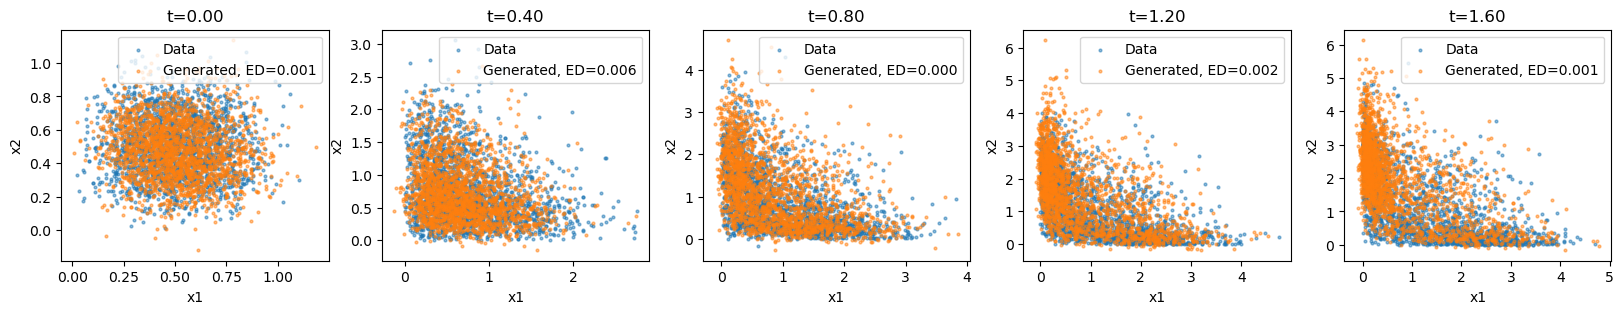

In [5]:
# Sample with ScoreMatching and overlay at each time point
fig, axes = plt.subplots(1, nsnaps, figsize=(4 * nsnaps, 3))
ED = score_reg.score(X)

for k in range(nsnaps):
    xk = samples_full[k][:2000]
    Xk = np.hstack([xk, tt[k] * np.ones((xk.shape[0], 1))])
    gen = score_reg.sample(Xk, nsamples=xk.shape[0])

    ax = axes[k]
    ax.scatter(xk[:, 0], xk[:, 1], s=4, alpha=0.5, label="Data")
    ax.scatter(gen[:, 0], gen[:, 1], s=4, alpha=0.5, label="Generated, ED=%.3f" % ED[k])
    ax.set_title(f"t={tt[k]:.2f}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.legend()

plt.show()


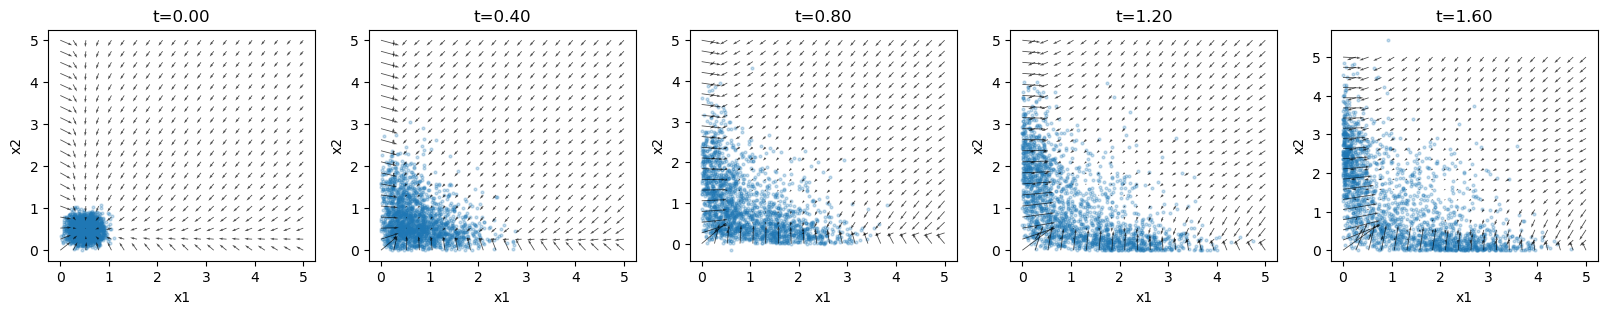

In [6]:
# Overlay score field arrows (2D) at each time
grid_n = 20
lims = (0, 5.0)
gx = np.linspace(lims[0], lims[1], grid_n)
gy = np.linspace(lims[0], lims[1], grid_n)
GX, GY = np.meshgrid(gx, gy)
grid = np.stack([GX.ravel(), GY.ravel()], axis=1)

fig, axes = plt.subplots(1, nsnaps, figsize=(4 * nsnaps, 3))
for k in range(nsnaps):
    xk = samples_full[k][:2000]
    ax = axes[k]
    ax.scatter(xk[:, 0], xk[:, 1], s=4, alpha=0.25)

    grid_full = np.zeros((grid.shape[0], ndim + 1))
    grid_full[:, :2] = grid
    grid_full[:, -1] = tt[k]
    scores = score_reg.predict(grid_full)

    ax.quiver(GX, GY, scores[:, 0].reshape(GX.shape), scores[:, 1].reshape(GY.shape),
              color="black", alpha=0.7)
    ax.set_title(f"t={tt[k]:.2f}")
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

plt.show()


In [7]:
# Fit flow model (FM) using the inferred score
from pfi.flow import FlowRegression
from pfi.flow.models import CLEFlow
from pfi.flow.interpolants import ChebyshevInterpolant

Np_flow = 25
drift_model = DNN([ndim, Np_flow, Np_flow, Np_flow, Np_flow, ndim], activation=nn.ELU(), seed=0).to(device)
growth_model = DNN([ndim, Np_flow, Np_flow, Np_flow, Np_flow, 1], activation=nn.ELU(), seed=0).to(device)

cle_model = CLEFlow(
    net=drift_model,
    score=score_reg.model_,
    Ndim=ndim,
    vol=vol,
    lx=1.0,
)

interp = ChebyshevInterpolant(device=device)

flow_reg = FlowRegression(
    interp=interp,
    model=cle_model,
    growth_model=growth_model,
    solver="fm",
    solver_kwargs=dict(n_epochs=3000, lr=1e-3, fac=1, alpha_ann=0.5),
    device=device,
)
flow_reg.fit(X)

/mnt/home/vchardes/.local/share/venvs/score/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


2003 500
[lambda-selection] Initial error: 0.9702
[lambda-selection] Best lambda (>=80% drop): 0.0100
[lambda-selection] Vel magnitudes: [0.97023934 0.94735277 0.92749643 0.90995741 0.88175261 0.83967233
 0.80227566 0.76977271 0.6733731  0.60676366 0.55512458 0.51248252
 0.41568607 0.36729944]


FM:   0%|          | 0/3000 [00:00<?, ?it/s]/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:287: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Dist = torch.tensor(Dist, dtype=torch.float32, device=device)
/mnt/home/vchardes/pfi/pfi/flow/solvers/_fm.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(weights, dtype=torch.float32, device=device)
FM:   0%|          | 10/3000 [00:00<00:30, 99.65it/s, loss=1.016e+00, lr=1.00e-03]

[epoch 0] inferred mass=[1.0000001  0.99855304 0.9940171  0.98846537 0.9828156 ] actual mass=tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


FM:  17%|█▋        | 516/3000 [00:05<00:24, 101.04it/s, loss=5.211e-03, lr=1.00e-03]

[epoch 500] inferred mass=[1.0000001 1.294838  1.7995076 2.696807  4.3416414] actual mass=tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


FM:  34%|███▍      | 1015/3000 [00:10<00:19, 103.26it/s, loss=3.296e-03, lr=1.00e-04]

[epoch 1000] inferred mass=[1.0000001 1.2815056 1.770745  2.6655421 4.360674 ] actual mass=tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


FM:  51%|█████     | 1519/3000 [00:14<00:14, 102.59it/s, loss=3.246e-03, lr=1.00e-05]

[epoch 1500] inferred mass=[1.0000001 1.2798057 1.7671008 2.6615918 4.363042 ] actual mass=tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


FM:  67%|██████▋   | 2014/3000 [00:19<00:09, 103.25it/s, loss=3.248e-03, lr=1.00e-05]

[epoch 2000] inferred mass=[1.0000001 1.2795852 1.7666253 2.6610599 4.3632746] actual mass=tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


FM:  84%|████████▎ | 2510/3000 [00:24<00:04, 103.97it/s, loss=3.597e-03, lr=1.00e-05]

[epoch 2500] inferred mass=[1.0000001 1.2792628 1.7659366 2.6603222 4.363761 ] actual mass=tensor([1.0000, 1.2526, 1.6890, 2.6206, 4.3929], device='cuda:0')


FM: 100%|██████████| 3000/3000 [00:29<00:00, 102.08it/s, loss=3.865e-03, lr=1.00e-05]


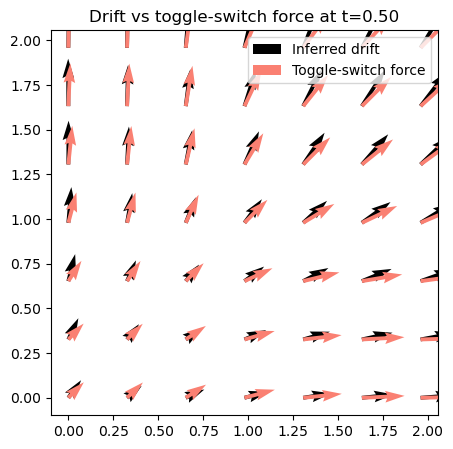

relative mean square error 0.0425623123685144


In [8]:
# Drift field overlay using drift_model (raw drift, no time input)
from pfi.utils import toggle_switch

viz_time = 0.5
Ngrid = 50
x_ = np.linspace(0, 2, Ngrid)
y_ = np.linspace(0, 2, Ngrid)
xx_, yy_ = np.meshgrid(x_, y_)

xtest = np.vstack([xx_.flatten(), yy_.flatten(), viz_time*np.ones((Ngrid**2,))]).T
force_true  = toggle_switch(xtest[:,0:ndim],model_params) 
xtest = torch.tensor(xtest , dtype=torch.float32, device=device)

drift_model.eval()
drift_inf  = drift_model(xtest[:,0:ndim]).cpu().data.numpy()

res = 8
plt.figure(figsize=(5, 5))
plt.quiver(xx_[::res, ::res], yy_[::res, ::res],
           drift_inf[:, 0].reshape(Ngrid, Ngrid)[::res, ::res],
           drift_inf[:, 1].reshape(Ngrid, Ngrid)[::res, ::res],
           width=0.01, scale=25, label='Inferred drift')
plt.quiver(xx_[::res, ::res], yy_[::res, ::res],
           force_true[:, 0].reshape(Ngrid, Ngrid)[::res, ::res],
           force_true[:, 1].reshape(Ngrid, Ngrid)[::res, ::res],
           color='salmon', width=0.01, scale=25, label='Toggle-switch force')
plt.legend(loc='best')
plt.title(f'Drift vs toggle-switch force at t={viz_time:.2f}')
plt.show()
print("relative mean square error", np.mean(((force_true - drift_inf)**2).sum(axis = -1))/np.mean(((force_true)**2).sum(axis = -1)))

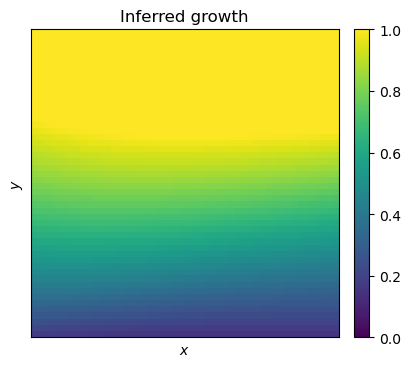

In [9]:
# Growth profile (2D)

x_ = np.linspace(0, 2, Ngrid)
y_ = np.linspace(0, 2, Ngrid)
xx_, yy_ = np.meshgrid(x_, y_)

xtest = np.vstack([xx_.flatten(), yy_.flatten()]).T
device = next(growth_model.parameters()).device
xtest_t = torch.tensor(xtest, dtype=torch.float32, device=device)

growth_model.eval()
with torch.no_grad():
    growth_inf = growth_model(xtest_t).squeeze(-1).cpu().numpy()

plt.figure(figsize=(5, 4))
plt.imshow(growth_inf.reshape(Ngrid, Ngrid), origin='lower', vmin=0, vmax=1)
plt.title('Inferred growth')
plt.xticks([]); plt.yticks([])
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.colorbar(pad=0.04, fraction=0.046)
plt.show()
